<a href="https://colab.research.google.com/github/mukulsn/Cement-Strength-Prediction/blob/master/HuggingFace/CLIP_model/faiss_with_hf_datasets_and_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######DATE : 18 August 2024
######INFO : this code is for image similarity using CLIP model

src:https://huggingface.co/learn/cookbook/en/faiss_with_hf_datasets_and_clip

# using myntra data try searching for pics and text using multimodel

In [3]:
!pip install aiofiles

In [1]:
# !mkdir pics
# !touch script.py
!python script.py

myntra class initiated <scrape_to_embedding.myntra object at 0x7bc3b5f8af80>
##### IMAGE DOWNLOADING COMPLETED ####
--- 5.104621171951294 seconds ---


In [4]:
import pandas as pd
import numpy as np
import PIL
import scrape_to_embedding as stem
import utility as u

df = pd.read_csv('/content/myntra 20d data 1 june 2024.csv')
data = df[['pid','name','brand','image1']].rename(columns={'image1':'pics','pid':'pid_modified'})

from datasets import Dataset
dataset = Dataset.from_pandas(data)
dataset[0]

{'pid_modified': 29184266,
 'name': '20Dresses Magenta Square Neck Tank Crop Top',
 'brand': '20Dresses',
 'pics': 'http://assets.myntassets.com/assets/images/29184266/2024/4/25/802ede92-7a82-48b0-a435-591ea27d181f171403089859620DressesWomenPocketsT-shirt1.jpg'}

In [14]:
# !pip install datasets

from datasets import load_dataset, Dataset, Image
import os

# Load your existing dataset (replace 'your_dataset_name' and 'your_config_name' as needed)
# dataset = load_dataset('your_dataset_name', 'your_config_name')

# Directory containing your images
image_dir = '/content/pics'

# Function to load image paths
def load_image_paths(example):
    image_filename = example['pid_modified']  # Replace with the column containing image filenames
    image_path = os.path.join(image_dir,str(image_filename)+'.jpg')
    # example['image'] = image_path

    # new line
    with open(image_path, 'rb') as f:
        example['image'] = f.read()
    ####
    return example

# Map the function to add the 'image' column with image paths
dataset = dataset.map(load_image_paths)

# Cast the 'image' column to Image type
dataset = dataset.cast_column('image',Image(decode=False))

# Now you can access images like this:
# example = dataset['train'][0]
# image = example['image']

Map:   0%|          | 0/2691 [00:00<?, ? examples/s]

In [ ]:
# import torch
# from PIL import Image
# from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
# import faiss
# import numpy as np

# device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
# processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

In [6]:
!cp metadata.jsonl pics/

In [8]:
import os
len([x for x in os.listdir('pics')])

2691

In [39]:
data.shape

(2691, 4)

In [5]:
import json
_new = [{'file_name':str(x)+'.jpg','text':y} for x,y in zip(data['pid_modified'],data['name'])]

with open('metadata.jsonl', 'w') as outfile:
    for entry in _new:
        json.dump(entry, outfile)
        outfile.write('\n')

In [10]:
from datasets import load_dataset
new_data = load_dataset("pics")
# new_data["train"][0]["image"]

Resolving data files:   0%|          | 0/2691 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
new_data['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1080x1440>,
 'text': '20Dresses Women Navy Blue & White Polka Dot Print Wrap Dress'}

In [14]:
dataset = new_data['train']
ds_with_embeddings2 = dataset.map(lambda example:
                                {'embeddings': model.get_text_features(
                                    **tokenizer([example["text"]],
                                                truncation=True, return_tensors="pt")
                                    .to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2690 [00:00<?, ? examples/s]

In [19]:
ds_with_embeddings2.add_faiss_index(column='embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text', 'embeddings', 'image_embeddings'],
    num_rows: 2690
})

In [16]:
ds_with_embeddings2 = ds_with_embeddings2.map(lambda example:
                                          {'image_embeddings': model.get_image_features(
                                              **processor([example["image"]],
                                                          return_tensors="pt")
                                              .to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2690 [00:00<?, ? examples/s]

In [17]:
ds_with_embeddings2.add_faiss_index(column='image_embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'text', 'embeddings', 'image_embeddings'],
    num_rows: 2690
})

In [58]:
ds_with_embeddings2[0]['image_embeddings']

[-0.4100685119628906,
 -0.22401539981365204,
 0.2409704625606537,
 0.5517843961715698,
 0.045960359275341034,
 0.2660285234451294,
 0.3574766516685486,
 0.5821470022201538,
 0.564675509929657,
 -0.04469073563814163,
 -0.021273642778396606,
 -0.06416358798742294,
 -0.034739598631858826,
 -0.019497081637382507,
 -0.2517601251602173,
 0.26822152733802795,
 0.3767106235027313,
 0.45576420426368713,
 -0.21219152212142944,
 -0.13491421937942505,
 0.8023160696029663,
 0.12797966599464417,
 -0.20196862518787384,
 0.16251061856746674,
 0.07519236207008362,
 -0.17933078110218048,
 -0.12199466675519943,
 -0.38892170786857605,
 -0.18533852696418762,
 0.0972433090209961,
 -0.021750284358859062,
 -0.026375357061624527,
 -0.012927122414112091,
 -0.0299433171749115,
 -0.1328962743282318,
 -0.321434885263443,
 -0.048151616007089615,
 -0.07247592508792877,
 -0.23693789541721344,
 1.1169588565826416,
 0.09262914955615997,
 0.05808551609516144,
 0.23762229084968567,
 0.1272442787885666,
 -0.47061875462532

['20Dresses Blue Floral Mini Dress']


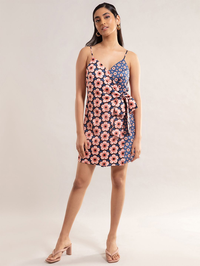

In [30]:
prmt = "blue dress with full sleeve"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings2.get_nearest_examples('embeddings', prmt_embedding, k=1)

def downscale_images(image):
  width = 200
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  return img

images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["text"])
display(images[0])



Image query

In [37]:
data.sample(5)['pics'].values

array(['http://assets.myntassets.com/assets/images/24329236/2023/8/3/754a6ecf-df23-433b-a6ad-ddf0605c0f98169107082933120DressesWomenBlackLooseT-shirt1.jpg',
       'http://assets.myntassets.com/assets/images/21311240/2022/12/26/ea60c36b-5d09-48dc-a752-6b30191c65e5167206413313920DressesOffWhiteTwistedStrapFlatsForWomen1.jpg',
       'http://assets.myntassets.com/assets/images/24457084/2023/8/11/95a4fd2c-1aa8-4dfd-82a2-2ef1de36e5b0169175664103820DressesPinkandGreyOmbreTurtleNeckFittedCropSweaterTopForWo1.jpg',
       'http://assets.myntassets.com/assets/images/28346856/2024/3/19/e08cd334-8036-42d1-aa43-82a1ad9698b7171082357205220DressesLightBlueSolidVestHighWaistPantsCoOrdSetForWomen1.jpg',
       'http://assets.myntassets.com/assets/images/16114516/2021/11/16/7f13b8ab-801f-422a-85b3-dc60a12f53ad163706602975120DressesBeigeMakeMeLookChicHandGlovesforwomen1.jpg'],
      dtype=object)

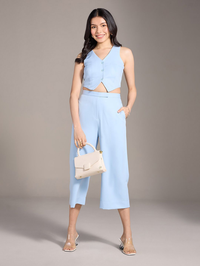

In [47]:
import requests
# image of a beaver
url = "http://assets.myntassets.com/assets/images/28346856/2024/3/19/e08cd334-8036-42d1-aa43-82a1ad9698b7171082357205220DressesLightBlueSolidVestHighWaistPantsCoOrdSetForWomen1.jpg"
image = Image.open(requests.get(url, stream=True).raw)
display(downscale_images(image))

In [48]:
img_embedding = model.get_image_features(**processor([image], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings2.get_nearest_examples('image_embeddings', img_embedding, k=1)

Unused or unrecognized kwargs: truncation.


In [50]:
scores

array([0.], dtype=float32)

['20Dresses Vest & High Waist Culottes Co-ords']


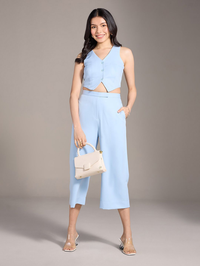

In [49]:
images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["text"])
display(images[0])

# Embedding multimodal data for similarity search using 🤗 transformers, 🤗 datasets and FAISS

_Authored by: [Merve Noyan](https://huggingface.co/merve)_

Embeddings are semantically meaningful compressions of information. They can be used to do similarity search, zero-shot classification or simply train a new model. Use cases for similarity search include searching for similar products in e-commerce, content search in social media and more.
This notebook walks you through using 🤗transformers, 🤗datasets and FAISS to create and index embeddings from a feature extraction model to later use them for similarity search.
Let's install necessary libraries.

In [1]:
!pip install -q datasets faiss-gpu transformers sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


For this tutorial, we will use [CLIP model](https://huggingface.co/openai/clip-vit-base-patch16) to extract the features. CLIP is a revolutionary model that introduced joint training of a text encoder and an image encoder to connect two modalities.

In [13]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = AutoImageProcessor.from_pretrained("openai/clip-vit-base-patch16")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

Load the dataset. To keep this notebook light, we will use a small captioning dataset, [jmhessel/newyorker_caption_contest](https://huggingface.co/datasets/jmhessel/newyorker_caption_contest).

In [3]:
from datasets import load_dataset

ds = load_dataset("jmhessel/newyorker_caption_contest", "explanation")

Generating train split:   0%|          | 0/2340 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/130 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/131 [00:00<?, ? examples/s]

See an example.

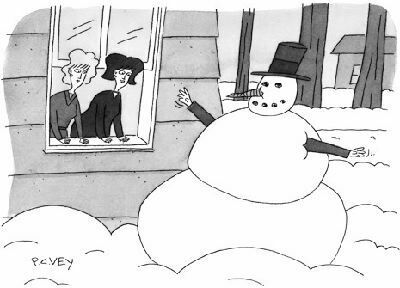

In [4]:
ds["train"][0]["image"]

In [5]:
ds["train"][0]["image_description"]

'Two women are looking out a window. There is snow outside, and there is a snowman with human arms.'

We don't have to write any function to embed examples or create an index. 🤗 datasets library's FAISS integration abstracts these processes. We can simply use `map` method of the dataset to create a new column with the embeddings for each example like below. Let's create one for text features on the prompt column.

In [66]:
dataset = ds["train"]
ds_with_embeddings = dataset.map(lambda example:
                                {'embeddings': model.get_text_features(
                                    **tokenizer([example["image_description"]],
                                                truncation=True, return_tensors="pt")
                                    .to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [67]:
ds_with_embeddings.add_faiss_index(column='embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings'],
    num_rows: 2340
})

We can do the same and get the image embeddings.

In [68]:
ds_with_embeddings = ds_with_embeddings.map(lambda example:
                                          {'image_embeddings': model.get_image_features(
                                              **processor([example["image"]], return_tensors="pt")
                                              .to("cuda"))[0].detach().cpu().numpy()})


Map:   0%|          | 0/2340 [00:00<?, ? examples/s]

In [73]:
ds_with_embeddings.add_faiss_index(column='image_embeddings')

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id', 'embeddings', 'image_embeddings'],
    num_rows: 2340
})

## Querying the data with text prompts

We can now query the dataset with text or image to get similar items from it.

In [74]:
prmt = "a snowy day"
prmt_embedding = model.get_text_features(**tokenizer([prmt], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('embeddings', prmt_embedding, k=1)

MissingIndex: Index with index_name 'embeddings' not initialized yet. Please make sure that you call `add_faiss_index` or `add_elasticsearch_index` first.

In [ ]:
def downscale_images(image):
  width = 200
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  return img

images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])



## Querying the data with image prompts

Image similarity inference is similar, where you just call `get_image_features`.

In [ ]:
import requests
# image of a beaver
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/beaver.png"
image = Image.open(requests.get(url, stream=True).raw)
display(downscale_images(image))

Search for the similar image.

In [ ]:
img_embedding = model.get_image_features(**processor([image], return_tensors="pt", truncation=True).to("cuda"))[0].detach().cpu().numpy()
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('image_embeddings', img_embedding, k=1)

Display the most similar image to the beaver image.

In [ ]:
images = [downscale_images(image) for image in retrieved_examples["image"]]
# see the closest text and image
print(retrieved_examples["image_description"])
display(images[0])

## Saving, pushing and loading the embeddings
We can save the dataset with embeddings with `save_faiss_index`.


In [ ]:
ds_with_embeddings.save_faiss_index('embeddings', 'embeddings/embeddings.faiss')

In [ ]:
ds_with_embeddings.save_faiss_index('image_embeddings', 'embeddings/image_embeddings.faiss')

It's a good practice to store the embeddings in a dataset repository, so we will create one and push our embeddings there to pull later.
We will login to Hugging Face Hub, create a dataset repository there and push our indexes there and load using `snapshot_download`.

In [ ]:
from huggingface_hub import HfApi, notebook_login, snapshot_download
notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.create_repo("merve/faiss_embeddings", repo_type="dataset")
api.upload_folder(
    folder_path="./embeddings",
    repo_id="merve/faiss_embeddings",
    repo_type="dataset",
)

In [ ]:
snapshot_download(repo_id="merve/faiss_embeddings", repo_type="dataset",
                  local_dir="downloaded_embeddings")

  We can load the embeddings to the dataset with no embeddings using `load_faiss_index`.

In [ ]:
ds = ds["train"]
ds.load_faiss_index('embeddings', './downloaded_embeddings/embeddings.faiss')
# infer again
prmt = "people under the rain"


In [ ]:
prmt_embedding = model.get_text_features(
                        **tokenizer([prmt], return_tensors="pt", truncation=True)
                        .to("cuda"))[0].detach().cpu().numpy()

scores, retrieved_examples = ds.get_nearest_examples('embeddings', prmt_embedding, k=1)

In [ ]:
display(retrieved_examples["image"][0])